In [1]:
3+2

5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
#from gsw import alpha, beta, cp_t_exact, sigma0

In [2]:
L = 4000000
dL = 500
dx = L/dL
dy = L/dL
#nz = 5
nz = 2
r0 = 6.378*10**6
omega = 7.2921*10**(-5)
g = 9.81
rho0 = 1025
f0 = 2*omega*np.sin(np.deg2rad(30))/r0
beta_f = 2*omega*np.cos(np.deg2rad(30))/r0

In [3]:
xu_ocean = np.linspace(0,L,dL+1,dtype = float)
yu_ocean = np.linspace(0,L,dL+1,dtype = float)
hu_ocean = -np.linspace(0,8,nz,dtype = float)*np.exp(np.linspace(0,8,nz,dtype = float)/2)

xt_ocean = (xu_ocean[0:dL] + xu_ocean[1:dL+1])/2
yt_ocean = (yu_ocean[0:dL] + yu_ocean[1:dL+1])/2
ht_ocean = (hu_ocean[0:nz-1] + hu_ocean[1:nz])/2

Y,X = np.meshgrid(yt_ocean,xt_ocean)

### MLD = 50 -> 240 with exponential

In [4]:
MLD_0 = -50*np.exp(1.57*X/L)

In [5]:
#Thermal expansion coefficient = 3.2e-4(10 deg) -> 2e-4(50 deg)
alpha = 2.5e-4
#Salinity coefficient beta = 7.1e-4(10 deg) -> 7.5e-4(50 deg)
beta = 7.3e-4
#Heat capacity cp = 3.99e3(10 deg) -> 4.01e3(50 deg)
cp = 4e3

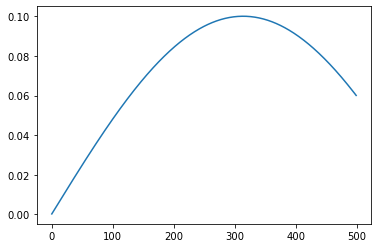

In [56]:
tau_x = 0.1*np.sin(2.5*yt_ocean/L)
plt.plot(tau_x)

### Evolution of equations

1. We have matrices of size (499,499) because we are considering the 

In [148]:
dt = 400
t_start = 0
t_end = 5000
f = f0 + beta_f*Y
um_old = np.zeros((dL,dL))
um_new = np.zeros((dL,dL))
vm_old = np.zeros((dL,dL))
vm_new = np.zeros((dL,dL))
S05_old = np.zeros((dL,dL))
S05_new = np.zeros((dL,dL))
rhom_old = 1025*np.ones((dL,dL))
rhom_new = np.zeros((dL,dL))
hm_new = np.zeros((dL,dL))
hm_old = -MLD_0
eta_old = np.zeros((dL,dL))
eta_new = np.zeros((dL,dL))
Qnet = 100*np.sin(4*Y/L + np.pi/2)
tau_x = 0.1*np.sin(2.5*Y/L)
tau_y = np.zeros((dL,dL))

for t in np.linspace(0,1000,int(t_end/dt)+1):
    #Ft = (g/rho0)*((alpha*Qnet/Cp) - rho0*beta*Snet)
    Ft = (g/rho0)*(alpha*Qnet/cp)
    
    if t == 0:
        um_old[0,1:dL-1] = 0
        vm_old[0,1:dL-1] = vm_old[1,1:dL-1]
        um_old[dL-1,1:dL-1] = 0
        vm_old[dL-1,1:dL-1] = vm_old[dL-1,1:dL-1]
        um_old[0:dL,0] = um_old[0:dL,1]
        vm_old[0:dL,0] = 0
        um_old[0:dL,dL-1] = um_old[0:dL,dL-1]
        vm_old[0:dL,dL-1] = 0
    
    
    #Governing Equations
    hm_new[1:dL-1,1:dL-1] = hm_old[1:dL-1,1:dL-1] - (
        dt/(2*dx))*(um_old[2:dL,1:dL-1]*hm_old[2:dL,1:dL-1] - um_old[0:dL-2,1:dL-1]*hm_old[0:dL-2,1:dL-1]) - (
        dt/(2*dy))*(vm_old[1:dL-1,2:dL]*hm_old[1:dL-1,2:dL] - vm_old[1:dL-1,0:dL-2]*hm_old[1:dL-1,0:dL-2]) - (
        dt*S05_old[1:dL-1,1:dL-1])
    
    rhom_new[1:dL-1,1:dL-1] = rhom_old[1:dL-1,1:dL-1] - (rho0/(g*hm_old[1:dL-1,1:dL-1]))*Ft[1:dL-1,1:dL-1] - (
        dt/(2*dx))*(um_old[2:dL,1:dL-1]*rhom_old[2:dL,1:dL-1]-um_old[0:dL-2,1:dL-1]*rhom_old[0:dL-2,1:dL-1])-(
        dt/(2*dy))*(vm_old[1:dL-1,2:dL]*rhom_old[1:dL-1,2:dL]-vm_old[1:dL-1,0:dL-2]*rhom_old[1:dL-1,0:dL-2])
    
    um_new[1:dL-1,1:dL-1] = um_old[1:dL-1,1:dL-1] - (
        dt/(2*dx))*(um_old[2:dL,1:dL-1]*um_old[2:dL,1:dL-1] - um_old[0:dL-2,1:dL-1]*um_old[0:dL-2,1:dL-1]) - (
        dt/(2*dy))*(um_old[1:dL-1,2:dL]*vm_old[1:dL-1,2:dL] - um_old[1:dL-1,0:dL-2]*vm_old[1:dL-1,0:dL-2]) + (
        dt*f[1:dL-1,1:dL-1]*vm_old[1:dL-1,1:dL-1]) - (
        (g*hm_old[1:dL-1,1:dL-1])/(2*rho0))*((dt/(2*dx))*(rhom_old[2:dL,1:dL-1]-rhom_old[0:dL-2,1:dL-1])) - (
        (g*rhom_old[1:dL-1,1:dL-1])/rho0)*((dt/(2*dx))*(eta_old[2:dL,1:dL-1]-eta_old[0:dL-2,1:dL-1])) + (
        dt*tau_x[1:dL-1,1:dL-1])/(rho0*hm_old[1:dL-1,1:dL-1])
    
    vm_new[1:dL-1,1:dL-1] = vm_old[1:dL-1,1:dL-1] - (
        dt/(2*dx))*(um_old[2:dL,1:dL-1]*vm_old[2:dL,1:dL-1] - um_old[0:dL-2,1:dL-1]*vm_old[0:dL-2,1:dL-1]) - (
        dt/(2*dy))*(vm_old[1:dL-1,2:dL]*vm_old[1:dL-1,2:dL] - vm_old[1:dL-1,0:dL-2]*vm_old[1:dL-1,0:dL-2]) - (
        f[1:dL-1,1:dL-1]*dt*um_old[1:dL-1,1:dL-1]) - (
        (g*hm_old[1:dL-1,1:dL-1])/(2*rho0))*((dt/(2*dy))*(rhom_old[1:dL-1,2:dL]-rhom_old[1:dL-1,0:dL-2])) - (
        (g*rhom_old[1:dL-1,1:dL-1])/rho0)*((dt/(2*dy))*(eta_old[1:dL-1,2:dL]-eta_old[1:dL-1,0:dL-2])) + (
        dt*tau_y[1:dL-1,1:dL-1])/(rho0*hm_old[1:dL-1,1:dL-1])
    
    
    #Boundary Conditions (I still need to think more about the 4 corner points for hm and rhom)
    um_new[0,1:dL] = 0
    vm_new[0,1:dL-1] = vm_new[1,1:dL-1]
    um_new[dL-1,0:dL] = 0
    vm_new[dL-1,1:dL-1] = vm_new[dL-1,1:dL-1]
    um_new[1:dL-1,0] = um_new[1:dL-1,1]
    vm_new[0:dL,0] = 0
    um_new[1:dL-1,dL-1] = um_new[1:dL-1,dL-1]
    vm_new[0:dL,dL-1] = 0
    
    hm_new[0,1:dL-1] = hm_old[0,1:dL-1] - (dt*S05_old[0,1:dL-1]) - vm_old[0,1:dL-1]*(
        dt/(2*dy))*(hm_old[0,2:dL] - hm_old[0,0:dL-2]) - hm_old[0,1:dL-1]*(
        dt/(2*dy))*(vm_old[0,2:dL] - vm_old[0,0:dL-2]) - hm_old[0,1:dL-1]*(
        dt/(2*dx))*(-3*um_old[0,1:dL-1] + 4*um_old[1,1:dL-1] - um_old[2,1:dL-1])
    hm_new[dL-1,1:dL-1] = hm_old[dL-1,1:dL-1] - (dt*S05_old[dL-1,1:dL-1]) - vm_old[dL-1,1:dL-1]*(
        dt/(2*dy))*(hm_old[dL-1,2:dL] - hm_old[dL-1,0:dL-2]) - hm_old[dL-1,1:dL-1]*(
        dt/(2*dy))*(vm_old[dL-1,2:dL] - vm_old[dL-1,0:dL-2]) - hm_old[dL-1,1:dL-1]*(
        dt/(2*dx))*(3*um_old[dL-1,1:dL-1] - 4*um_old[dL-2,1:dL-1] + um_old[dL-3,1:dL-1])
    hm_new[1:dL-1,0] = hm_old[1:dL-1,0] - (dt*S05_old[1:dL-1,0]) - um_old[1:dL-1,0]*(
        dt/(2*dx))*(hm_old[2:dL,0] - hm_old[0:dL-2,0]) - hm_old[1:dL-1,0]*(
        dt/(2*dx))*(um_old[2:dL,0] - um_old[0:dL-2,0]) - hm_old[1:dL-1,0]*(
        dt/(2*dy))*(-3*um_old[1:dL-1,0] + 4*um_old[1:dL-1,1] - um_old[1:dL-1,2])
    hm_new[1:dL-1,dL-1] = hm_old[1:dL-1,dL-1] - (dt*S05_old[1:dL-1,dL-1]) - um_old[1:dL-1,dL-1]*(
        dt/(2*dx))*(hm_old[2:dL,dL-1] - hm_old[0:dL-2,dL-1]) - hm_old[1:dL-1,dL-1]*(
        dt/(2*dx))*(um_old[2:dL,dL-1] - um_old[0:dL-2,dL-1]) - hm_old[1:dL-1,dL-1]*(
        dt/(2*dy))*(3*vm_old[1:dL-1,dL-1] - 4*vm_old[1:dL-1,dL-2] + vm_old[1:dL-1,dL-3])
    
    rhom_new[0,1:dL-1] = rhom_old[0,1:dL-1] - ((dt*alpha*Qnet[0,1:dL-1])/(cp*hm_old[0,1:dL-1])) - (
        dt/(2*dx))*(rhom_old[0,1:dL-1])*(-3*um_old[0,1:dL-1] + 4*um_old[1,1:dL-1] - um_old[2,1:dL-1]) - (
        dt/(2*dy*hm_old[0,1:dL-1]))*(rhom_old[0,2:dL]*vm_old[0,2:dL]*hm_old[0,2:dL] - 
                                     rhom_old[0,0:dL-2]*vm_old[0,0:dL-2]*hm_old[0,0:dL-2])
    rhom_new[dL-1,1:dL-1] = rhom_old[dL-1,1:dL-1] - ((dt*alpha*Qnet[dL-1,1:dL-1])/(cp*hm_old[dL-1,1:dL-1])) - (
        dt/(2*dx))*(rhom_old[dL-1,1:dL-1])*(3*um_old[dL-1,1:dL-1] - 4*um_old[dL-2,1:dL-1] + um_old[dL-3,1:dL-1])- (
        dt/(2*dy*hm_old[dL-1,1:dL-1]))*(rhom_old[dL-1,2:dL]*vm_old[dL-1,2:dL]*hm_old[dL-1,2:dL] - 
                                        rhom_old[dL-1,0:dL-2]*vm_old[dL-1,0:dL-2]*hm_old[dL-1,0:dL-2])
    rhom_new[1:dL-1,dL-1] = rhom_old[1:dL-1,dL-1] - ((dt*alpha*Qnet[1:dL-1,dL-1])/(cp*hm_old[1:dL-1,dL-1])) - (
        dt/(2*dy))*(rhom_old[1:dL-1,dL-1])*(3*vm_old[1:dL-1,dL-1] - 4*vm_old[1:dL-1,dL-2] + vm_old[1:dL-1,dL-3])- (
        dt/(2*dx*hm_old[1:dL-1,dL-1]))*(rhom_old[2:dL,dL-1]*um_old[2:dL,dL-1]*hm_old[2:dL,dL-1] - 
                                        rhom_old[0:dL-2,dL-1]*um_old[0:dL-2,dL-1]*hm_old[0:dL-2,dL-1])
    rhom_new[1:dL-1,0] = rhom_old[1:dL-1,0] - ((dt*alpha*Qnet[1:dL-1,0])/(cp*hm_old[1:dL-1,0])) - (
        dt/(2*dy))*(rhom_old[1:dL-1,0])*(-3*vm_old[1:dL-1,0] + 4*vm_old[1:dL-1,1] - vm_old[1:dL-1,2]) - (
        dt/(2*dx*hm_old[1:dL-1,0]))*(rhom_old[2:dL,0]*um_old[2:dL,0]*hm_old[2:dL,0] - 
                                     rhom_old[0:dL-2,0]*um_old[0:dL-2,0]*hm_old[0:dL-2,0])
                                     
    #Just putting random values for the 4 corner points
    rhom_new[0,0] = rhom_new[1,1]
    rhom_new[dL-1,0] = rhom_new[dL-2,1]
    rhom_new[0,dL-1] = rhom_new[1,dL-2]
    rhom_new[dL-1,dL-1] = rhom_new[dL-2,dL-2]
    
    hm_new[0,0] = hm_new[1,1]
    hm_new[dL-1,0] = hm_new[dL-2,1]
    hm_new[0,dL-1] = hm_new[1,dL-2]
    hm_new[dL-1,dL-1] = hm_new[dL-2,dL-2]

    #Updation Equations
    um_old = um_new
    vm_old = vm_new
    rhom_old = rhom_new
    hm_old = hm_new
    
    print('Step Complete')

Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete
Step Complete


In [149]:
hm_new[dL-1,dL-1]

238.3884120520322

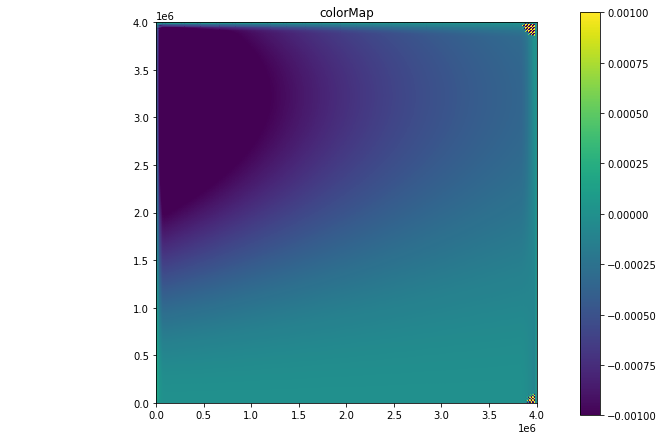

In [154]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.pcolormesh(X, Y, vm_new, shading = 'nearest', vmin = -1e-3, vmax = 1e-3)#, cmap = 'Greens')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

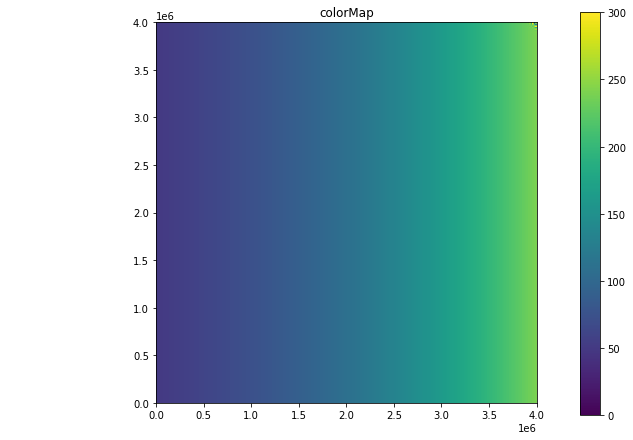

In [151]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.pcolormesh(X, Y, hm_new, shading = 'nearest', vmin = 0, vmax = 300)#, cmap = 'Greens')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()